In [154]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

import folium
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
from google.cloud import bigquery
import pandas_gbq
import geopandas as gpd
from shapely.geometry import Point
import shapely.wkt
from geopy.geocoders import Nominatim
from matplotlib import pyplot as plt



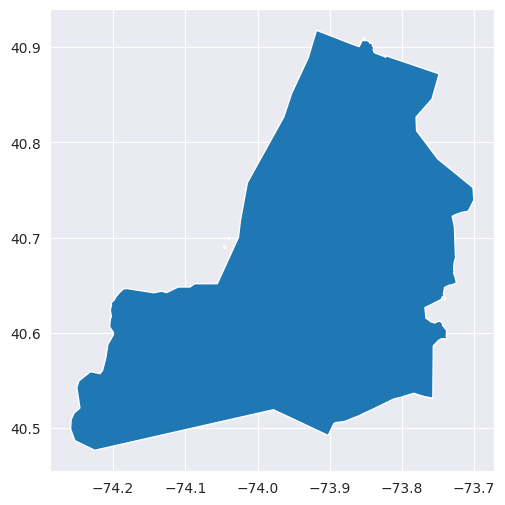

In [155]:
REGION = "New York City"


geolocator = Nominatim(user_agent="myGeocoder")

# Get the bounding box of the city
location = geolocator.geocode(REGION, exactly_one=True, geometry="wkt")
raw_geotext = location.raw['geotext']
polygon = shapely.wkt.loads(raw_geotext)

gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])

# Calculate the mean latitude and longitude
center_lat = polygon.centroid.y
center_lon = polygon.centroid.x

# Get the shape of the city from the GeoDataFrame
region_polygon = gdf['geometry'].unary_union
gdf.plot(figsize=(6, 6))
plt.show()

In [156]:
# Create a folium map
m = folium.Map(location=[center_lat,center_lon], zoom_start=10)

# Add the GeoJSON data to the map
folium.GeoJson(region_polygon).add_to(m)
m
# Save the map to an HTML file

In [157]:
# Load the data
client = bigquery.Client()
df = pandas_gbq.read_gbq('shopify.orders', project_id=client.project)
# Remove rows with missing 'shipping_latitude' and 'shipping_longitude' values
df_clean = df.dropna(subset=['shipping_latitude', 'shipping_longitude'])

Downloading: 100%|██████████|


In [158]:
df_clean = df_clean.copy()
df_clean['point'] = df_clean.apply(lambda row: Point(row['shipping_longitude'], row['shipping_latitude']), axis=1)
df_region = df_clean[df_clean['point'].apply(lambda point: point.within(region_polygon))]

In [159]:
# Prepare data for DBSCAN
coords_city = df_region[['shipping_latitude', 'shipping_longitude']].values


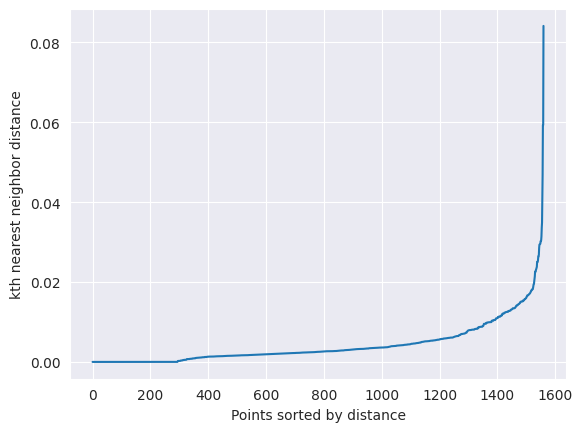

In [160]:

# Fit a nearest neighbors estimator
nn = NearestNeighbors(n_neighbors=5)
nn.fit(coords_city)

# Get the distances to the kth nearest neighbor
distances, _ = nn.kneighbors(coords_city)
distances = np.sort(distances[:, -1])

# Plot the k-distance graph
plt.plot(distances)
plt.ylabel('kth nearest neighbor distance')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.show()

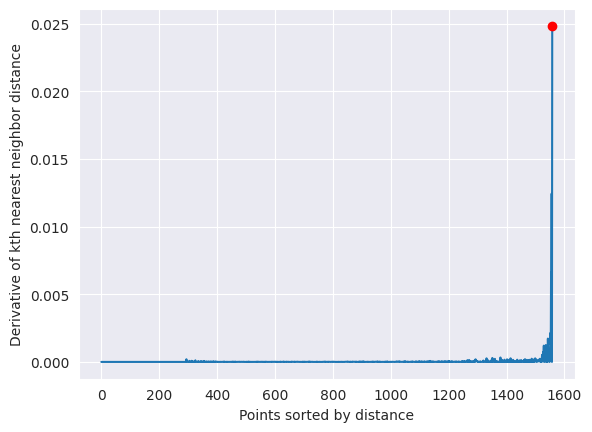

Suggested eps value: 0.05932162811362746


In [161]:
# Calculate the derivative of the distances
derivatives = np.diff(distances)

# Find the index of the maximum derivative
max_derivative_index = np.argmax(derivatives)

# Plot the derivative
plt.plot(derivatives)
plt.plot(max_derivative_index, derivatives[max_derivative_index], 'ro')  # highlight max derivative point
plt.ylabel('Derivative of kth nearest neighbor distance')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.show()

print(f"Suggested eps value: {distances[max_derivative_index]}")


In [162]:
EPS = 0.01
# Run DBSCAN for the city
db_city = DBSCAN(eps=EPS, min_samples=5)
db_city.fit(coords_city)

DBSCAN(eps=0.01)

In [163]:
# Get labels and number of clusters from DBSCAN
labels_city = db_city.labels_
n_clusters_city = len(set(labels_city)) - (1 if -1 in labels_city else 0)

In [164]:
# Prepare data for GMM (exclude noise points)
coords_gmm_city = coords_city[labels_city != -1]

In [165]:
# Run GMM for the city with a reduced number of clusters
gmm_city = GaussianMixture(n_components=min(n_clusters_city, 10), covariance_type='full')
gmm_city.fit(coords_gmm_city)


GaussianMixture(n_components=10)

In [166]:
# Get labels from GMM for the city
labels_gmm_city = gmm_city.predict(coords_gmm_city)

In [167]:
# Calculate center of map for the city
city_center_lat, city_center_lon = df_region['shipping_latitude'].mean(), df_region['shipping_longitude'].mean()

In [168]:
# Create a DataFrame for the GMM results for the city
df_gmm_city = pd.DataFrame(coords_gmm_city, columns=['latitude', 'longitude'])
df_gmm_city['label'] = labels_gmm_city


In [169]:
# Find the centroid of each cluster for the city
centroids_city = df_gmm_city.groupby('label')[['latitude', 'longitude']].mean().reset_index()

In [170]:
# Find the lat/lng boundaries of each cluster for the city
boundaries_city = df_gmm_city.groupby('label')[['latitude', 'longitude']].agg(['min', 'max']).reset_index()

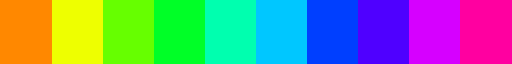

In [171]:
# Create a colormap for the city
cmap_city = ListedColormap(sns.color_palette("hsv", min(n_clusters_city, 10)).as_hex())
cmap_city

In [172]:

# Create folium map centered on the city
city_map = folium.Map(location=[city_center_lat, city_center_lon], zoom_start=10)

nm = []
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'black', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add clusters to map with improved color coding
for lat, lon, label in zip(coords_gmm_city[:, 0], coords_gmm_city[:, 1], labels_gmm_city):
    nm.append(cmap_city(label))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=colors[label],
        fill=True,
        fill_color=colors[label],
        fill_opacity=0.7
    ).add_to(city_map)

# Superimpose bounding boxes onto the folium map
for _, row in boundaries_city.iterrows():
    folium.Rectangle(
        [[row[('latitude', 'min')], row[('longitude', 'min')]], [row[('latitude', 'max')], row[('longitude', 'max')]]],
        color='blue',
        fill=False
    ).add_to(city_map)


# Save the updated map to an HTML file
city_map

In [173]:
city_map.save('city_order_clusters_colormap_bounds.html')
